In [1]:
%run ../base_setup.ipynb

Foundation: 2.11.012
Transition: 2.11.014
Engines   : 2.03.027
Behavioral: 2.06.033


In [2]:
# task grouping name
task_name = 'members'

-------------------------
## Synthetic Builder

In [3]:
builder = SyntheticBuilder.from_env(task_name)

In [4]:
tools = builder.intent_model

In [5]:
builder.pm.reset_intents()
builder.pm_persist()

In [6]:
sample_size = 1000
df = pd.DataFrame(index=range(sample_size))

-----------
### Distribution elements

In [7]:
# member_id
df['member_id'] = tools.get_number(from_value=100000000, to_value=999999789, at_most=1, size=sample_size, column_name='member_id')
builder.add_column_description(column_name='member_id', description="a unique id for the member")

In [8]:
df = tools.model_sample_map(canonical=df, sample_map='us_persona', female_bias=0.55, column_name='persona')
builder.add_column_description(column_name='persona', description="a base person template")

In [9]:
state_code = ['CA', 'NY', 'LA', 'NJ', 'VA', 'CO', 'NV', 'GA', 'IN', 'OH', 'KY', 'ME', 'MO', 'WI']
df = tools.model_sample_map(canonical=df, sample_map='us_zipcode', state_filter=state_code, column_name='zipcodes')
builder.add_column_description(column_name='zipcodes', description="Only covering 14 states woth a distribution based on population density")

In [10]:
# build up address starting with a number
df['address'] = tools.get_number(from_value=1, to_value=300000, precision=0, relative_freq=[50,10,5,3,2,1,1,1,1,], size=sample_size, column_name='address', intent_order=0)
builder.add_column_description(column_name='address', description="A realistc non-complex address")

In [11]:
# add in a name
df['address'] = tools.correlate_join(df, header='address', sep=' ', action=tools.action2dict(method='get_sample', sample_name='us_street_names', shuffle=True), column_name='address', intent_order=1)

In [12]:
# add road, sep=' ' types
df['address'] = tools.correlate_join(df, header='address', sep=' ', action=tools.action2dict(method='get_sample', sample_name='us_street_types', shuffle=True), column_name='address', intent_order=2)

In [13]:
# has phone number
df['has_phone_number'] = tools.get_category(selection=[1, 0], relative_freq=[15,1], size=sample_size, column_name='has_phone_number')
builder.add_column_description(column_name='has_phone_number', description="If the person has a phone number on record.")

In [14]:
# ensure only thoise with Phone numbers elect to not be called
selection = [builder.tools.select2dict(column='has_phone_number', condition='@==1')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[1,20])
default = builder.tools.action2dict(method='@constant', value=0)

df['do_not_call'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='do_not_call')
builder.add_column_description(column_name='do_not_call', description="If the member has elected not to be called. Must have a phone number")

In [15]:
# communication channel preference
channels = ["SydneyCare", "RCP", "Phone", "Email", "SMS", "AgentAssist"]
df['channel_pref'] = tools.get_category(selection=channels, relative_freq=[4,1,3,2,2, 0.1], size=sample_size, column_name='channel_pref', intent_order=-1)
builder.add_column_description(column_name='channel_pref', description="The channel through which the member can be contacted")

In [16]:
# ensure if the preference is do not call the channel preference is not Phone
selection = [builder.tools.select2dict(column='do_not_call', condition='@==1'),
             builder.tools.select2dict(column='channel_pref', condition="@=='Phone'", logic='AND')]

action = builder.tools.action2dict(method='get_category', selection=["SydneyCare", "RCP", "Email", "SMS", "AgentAssist"], relative_freq=[2,1,2,2,0.1])
default = builder.tools.action2dict(method='@header', header='channel_pref')

df['channel_pref'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='channel_pref', intent_order=-1)
builder.add_column_description(column_name='channel_pref', description="ensure that if do_not_call is true the preference isn't by phone")

In [17]:
# ensure if the member has no phone number the channel preference is not SMS or Phone
selection = [builder.tools.select2dict(column='has_phone_number', condition='@==0')]

action = builder.tools.action2dict(method='get_category', selection=["SydneyCare", "RCP", "Email", "AgentAssist"], relative_freq=[2,1,2, 0.1])
default = builder.tools.action2dict(method='@header', header='channel_pref')

df['channel_pref'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='channel_pref', intent_order=-1)
builder.add_column_description(column_name='channel_pref', description="ensure if the member has no phone number the channel preference is not SMS or Phone")

In [18]:
# healthcare segment 
segment = ["Local Group", "National Accounts", "Medicaid", "BlueCard", "Medicare", "FEP", "Individual"]
df['segment'] = tools.get_category(selection=segment, relative_freq=[38, 19, 18, 15, 5, 4, 2], size=sample_size, column_name='segment')
builder.add_column_description(column_name='segment', description="The heathcare segment of the member with bias weighting")

In [19]:
# # line of buisness
correlations = [["Medicaid", "Medicare"]]
actions = {0: tools.action2dict(method='@constant', value='Business')}

df['line_of_business'] = tools.correlate_categories(df, header='segment', correlations=correlations, actions=actions, default_action='Commercial', column_name='line_of_business')
builder.add_column_description(column_name='line_of_business', description="The line of business this segment is in")

In [20]:
# data of birth
df['dob'] = tools.get_datetime(start=-36000, until=-6600, relative_freq=[0.01, 0.1, 1, 2, 3, 4, 2, 3], date_format='%Y-%m-%d', size=sample_size, column_name='dob')
builder.add_column_description(column_name='dob', description="dob has a distribution that peaks around the mid 40's with a negative skew and older outliers")

In [21]:
df['age'] = tools.correlate_dates(df, header='dob', now_delta='Y', year_first=True, column_name='age')
builder.add_column_description(column_name='age', description="converts the dob into an age as of today for reference in other attributes selections")

<AxesSubplot:xlabel='age', ylabel='Density'>

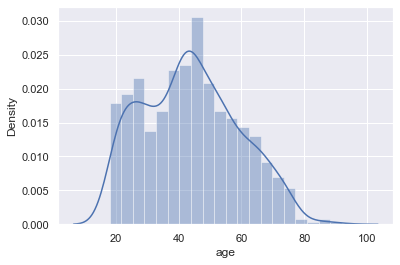

In [22]:
sns.set()
sns.distplot(df['age'], bins=20)

In [23]:
# Adjust age for medicare being over 65
selection = [tools.select2dict(column='segment', condition="@=='Medicare'")]

action = tools.action2dict(method='get_number', from_value=65, to_value=90, relative_freq=[4,1,0.1])
default = tools.action2dict(method='@header', header='age')

df['age'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='age', intent_order=-1)
builder.add_column_description(column_name='segment', description="Age is a conditional influencer with Medicare being exclusivly over 65")

In [24]:
# remove some emails addresses for over 60's
selection = [builder.tools.select2dict(column='age', condition='@ >= 60')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[50, 1])

df['has_email'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=1, column_name='has_email')
builder.add_column_description(column_name='has_email', description="If the member has an email address on record")

In [25]:
# match the email to the has_email
selection = [builder.tools.select2dict(column='has_email', condition='@ == 0')]

action = tools.action2dict(method='@constant', value="")
default = tools.action2dict(method='@header', header='email')

df['email'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='email')
builder.add_column_description(column_name='email', description="trimming those with email address for over 60s from the persona emails")

In [26]:
# prev_flu_shot
df['prev_flu_shot'] = tools.get_category(selection=[1, 0], relative_freq=[4.5, 5.5], size=sample_size, column_name='prev_flu_shot', intent_order=-1)
builder.add_column_description(column_name='prev_flu_shot', description="If the member has had a flu shot in the previous season. Distribution based upon the figures taken from The Advisory Committee on Immunization Practices (ACIP)")

In [27]:
# adjust previous flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<49')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[3,7])
default = builder.tools.action2dict(method='@header', header='prev_flu_shot')

df['prev_flu_shot'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prev_flu_shot', intent_order=-1)

In [28]:
# adjust flu shot for over 75
selection = [builder.tools.select2dict(column='age', condition='@>65')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[6.5, 3.5])
default = builder.tools.action2dict(method='@header', header='prev_flu_shot')

df['prev_flu_shot'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prev_flu_shot', intent_order=-1)

In [29]:
# add a date in if previous flushot
selection = [builder.tools.select2dict(column='prev_flu_shot', condition='@==1')]

action = builder.tools.action2dict(method='get_datetime', start=-600, until=-300, relative_freq=[20, 10, 5, 1], ignore_time=True, date_format='%Y-%m-%d')
default = builder.tools.action2dict(method='@constant', value='')

df['last_flu_shot_date'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='last_flu_shot_date')
builder.add_column_description(column_name='last_flu_shot_date', description="if had a previous flu shot, a date between 300 and 600 days previous to today")


In [30]:
# member health plan
df['member_health_plan'] = tools.get_category(selection=['PPO', 'HMO'], relative_freq=[6, 4], size=sample_size, column_name='member_health_plan')
builder.add_column_description(column_name='member_health_plan', description="The member health plan")

### Asign a PCP to each member

In [31]:
# assign PCP tax_id
sample_data = tools.action2dict(method='model_sample_map', canonical=tools.action2dict(method='@empty'), sample_map='us_healthcare_practitioner', headers=['city', 'pcp_tax_id'], shuffle=False)
merge_data = tools.action2dict(method='model_group', canonical=sample_data, headers='pcp_tax_id', group_by='city', aggregator='list')
df = tools.model_merge(df, merge_data, how='left', left_on='city', right_on='city', column_name='pcp_tax_id')
builder.add_column_description(column_name='pcp_tax_id', description="Taken from the sample healthcare practitioners, matches a city to a practitioner list")

In [32]:
# select one of the options from the pcp_tax_id list
df['pcp_tax_id'] = tools.correlate_choice(df, header='pcp_tax_id', list_size=1, random_choice=True, shuffle=False, column_name='pcp_tax_id')

In [33]:
# is PCP auto assigned where there is a pc_tax_id
selection = [builder.tools.select2dict(column='pcp_tax_id', condition='@.isna()')]

df['is_PCP_auto_assigned'] = tools.correlate_selection(df, selection=selection, action=0, default_action=1, column_name='is_PCP_auto_assigned')
builder.add_column_description(column_name='is_PCP_auto_assigned', description="if the PCP has been auto assigned with a 7/3 positive distribution")

### Run Reports

In [34]:
builder.canonical_report(df)

,Attributes (26),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,object,0.0%,0.1%,1000,1000,Sample: 18533 Knaith Ville | 12019 Coronet Path | 10710 Puxton Expressway | 24788 Clitheroe Camp | 5...
1,age,int64,0.0%,3.5%,1000,66,max=92 | min=18 | mean=45.01 | dominant=44
2,channel_pref,object,0.0%,34.3%,1000,6,Sample: SydneyCare | Phone | Email | SMS | RCP
3,city,object,0.0%,1.8%,1000,835,Sample: New York | Los Angeles | Manhattan | Roanoke | Sacramento
4,county,object,0.0%,3.7%,1000,401,Sample: Los Angeles | Jefferson | New York | Hamilton | Nassau
5,county_fips,int64,0.0%,3.7%,1000,483,max=55141 | min=6001 | mean=26102.23 | dominant=6037
6,do_not_call,int64,0.0%,95.4%,1000,2,max=1 | min=0 | mean=0.05 | dominant=0
7,dob,object,0.0%,0.2%,1000,976,Sample: 1973-03-29 | 1978-05-19 | 1971-12-10 | 1981-08-18 | 1970-06-15
8,email,object,0.5%,0.5%,1000,996,Sample: | avahlynn.tomm@google.com | nami.murfin@gmx.com | murray.ruggerio@aol.com | judie.cardey@j...
9,family_name,object,0.0%,0.2%,1000,994,Sample: Hurvitz | Clemons | Berthelson | Tardugno | Dvoracek


In [35]:
builder.report_column_catalog()

,column_name,description
0,address,A realistc non-complex address
1,age,converts the dob into an age as of today for reference in other attributes selections
2,channel_pref,"The channel through which the member can be contacted, ensure that if do_not_call is true the preference isn't by phone, ensure if the member has no phone number the channel preference is not SMS or Phone"
3,do_not_call,If the member has elected not to be called. Must have a phone number
4,dob,dob has a distribution that peaks around the mid 40's with a negative skew and older outliers
5,email,trimming those with email address for over 60s from the persona emails
6,has_email,If the member has an email address on record
7,has_phone_number,If the person has a phone number on record.
8,is_PCP_auto_assigned,if the PCP has been auto assigned with a 7/3 positive distribution
9,last_flu_shot_date,"if had a previous flu shot, a date between 300 and 600 days previous to today"


In [36]:
builder.report_intent()

,level,order,intent,parameters,creator
0,address,0,get_number,"['from_value=1', 'to_value=300000', 'relative_freq=[50, 10, 5, 3, 2, 1, 1, 1, 1]', 'precision=0', ""column_name='address'""]",doatridge
1,,1,correlate_join,"[""header='address'"", ""action={'method': 'get_sample', 'sample_name': 'us_street_names', 'shuffle': True}"", ""sep=' '"", ""column_name='address'""]",doatridge
2,,2,correlate_join,"[""header='address'"", ""action={'method': 'get_sample', 'sample_name': 'us_street_types', 'shuffle': True}"", ""sep=' '"", ""column_name='address'""]",doatridge
3,age,0,correlate_dates,"[""header='dob'"", ""now_delta='Y'"", 'year_first=True', ""column_name='age'""]",doatridge
4,,1,correlate_selection,"['selection=[{\'column\': \'segment\', \'condition\': ""@==\'Medicare\'""}]', ""action={'method': 'get_number', 'from_value': 65, 'to_value': 90, 'relative_freq': [4, 1, 0.1]}"", ""default_action={'method': '@header', 'header': 'age'}"", ""column_name='age'""]",doatridge
5,channel_pref,0,get_category,"[""selection=['SydneyCare', 'RCP', 'Phone', 'Email', 'SMS', 'AgentAssist']"", 'relative_freq=[4, 1, 3, 2, 2, 0.1]', ""column_name='channel_pref'""]",doatridge
6,,1,correlate_selection,"['selection=[{\'column\': \'do_not_call\', \'condition\': \'@==1\'}, {\'column\': \'channel_pref\', \'condition\': ""@==\'Phone\'"", \'logic\': \'AND\'}]', ""action={'method': 'get_category', 'selection': ['SydneyCare', 'RCP', 'Email', 'SMS', 'AgentAssist'], 'relative_freq': [2, 1, 2, 2, 0.1]}"", ""default_action={'method': '@header', 'header': 'channel_pref'}"", ""column_name='channel_pref'""]",doatridge
7,,2,correlate_selection,"[""selection=[{'column': 'has_phone_number', 'condition': '@==0'}]"", ""action={'method': 'get_category', 'selection': ['SydneyCare', 'RCP', 'Email', 'AgentAssist'], 'relative_freq': [2, 1, 2, 0.1]}"", ""default_action={'method': '@header', 'header': 'channel_pref'}"", ""column_name='channel_pref'""]",doatridge
8,do_not_call,0,correlate_selection,"[""selection=[{'column': 'has_phone_number', 'condition': '@==1'}]"", ""action={'method': 'get_category', 'selection': [1, 0], 'relative_freq': [1, 20]}"", ""default_action={'method': '@constant', 'value': 0}"", ""column_name='do_not_call'""]",doatridge
9,dob,0,get_datetime,"['start=-36000', 'until=-6600', 'relative_freq=[0.01, 0.1, 1, 2, 3, 4, 2, 3]', ""date_format='%Y-%m-%d'"", ""column_name='dob'""]",doatridge


## Run the Pipeline  save the Schema and show the Canonical Report

In [37]:
# run the pipeline
builder.run_synthetic_pipeline(size=sample_size)

# report the stored schema
builder.canonical_report(builder.load_synthetic_canonical(), stylise=True)

,Attributes (26),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,object,0.0%,0.1%,1000,1000,Sample: 36750 Wells Point Hills | 27880 Buckley Motorway | 1558 Meadow Rapid | 36453 Percy Cliff | 8...
1,age,int64,0.0%,3.1%,1000,69,max=89 | min=18 | mean=45.26 | dominant=40
2,channel_pref,object,0.0%,33.0%,1000,6,Sample: SydneyCare | Phone | Email | SMS | RCP
3,city,object,0.0%,1.6%,1000,836,Sample: New York | Los Angeles | San Diego | San Jose | Manhattan
4,county,object,0.0%,3.3%,1000,388,Sample: Jefferson | Los Angeles | New York | Nassau | Hamilton
5,county_fips,int64,0.0%,2.9%,1000,468,max=55141 | min=6001 | mean=27184.97 | dominant=6037
6,do_not_call,int64,0.0%,94.6%,1000,2,max=1 | min=0 | mean=0.05 | dominant=0
7,dob,object,0.0%,0.2%,1000,975,Sample: 1979-05-04 | 1953-12-21 | 2001-04-01 | 1974-01-22 | 1963-12-17
8,email,object,0.5%,0.5%,1000,996,Sample: | kourtney.cimon@rocketmail.com | patrice.sankoh@comcast.net | kyla.wenderski@bellsouth.net...
9,family_name,object,0.0%,0.2%,1000,999,Sample: Munnerlyn | Denetclaw | Behle | Slanec | Dalporto


-------------------------
-------------------------
## Members Transition

In [38]:
tr = Transition.from_env(task_name)

In [39]:
tr.pm.reset_intents()
tr.pm_persist()

In [40]:
df = tr.load_source_canonical()

In [41]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_str_type(df, headers=['address', 'city', 'county', 'state', 'first_name', 'family_name', 'middle_name', 'email'], use_string_type=True, inplace=True)
tr.cleaners.to_date_type(df, headers='last_flu_shot_date', inplace=True)
tr.cleaners.to_remove(df, headers=['prev_flu_shot', 'age', 'county_fips'], inplace=True)

In [42]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [43]:
# run the pipeline
tr.run_transition_pipeline()

# report the stored schema
tr.canonical_report(tr.load_clean_canonical(), stylise=True)

,Attributes (23),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,string,0.0%,0.1%,1000,1000,Sample: 36750 Wells Point Hills | 27880 Buckley Motorway | 1558 Meadow Rapid | 36453 Percy Cliff | 8...
1,channel_pref,category,0.0%,33.0%,1000,6,Sample: SydneyCare | Phone | Email | SMS | RCP
2,city,string,0.0%,1.6%,1000,836,Sample: New York | Los Angeles | San Diego | San Jose | Manhattan
3,county,string,0.0%,3.3%,1000,388,Sample: Jefferson | Los Angeles | New York | Nassau | Hamilton
4,do_not_call,bool,0.0%,94.6%,1000,2,False | True
5,dob,datetime64[ns],0.0%,0.2%,1000,975,max=2002-12-25 00:00:00 | min=1932-09-23 00:00:00 | yr mean= 1976
6,email,string,0.5%,0.5%,1000,996,Sample: chanell.reuber@protonmail.com | suha.mazzella@bellsouth.net | mariangel.ijames@earthlink.net...
7,family_name,string,0.0%,0.2%,1000,999,Sample: Munnerlyn | Denetclaw | Behle | Slanec | Dalporto
8,first_name,string,0.0%,0.2%,1000,998,Sample: Jasani | Lyn | Soul | Raimondo | Bryant
9,gender,category,0.0%,54.9%,1000,2,Sample: F | M


-------------------------
## Hello World Members Transition

In [44]:
tr_hw = Transition.from_env('hello_world_members')

In [45]:
tr_hw.pm.reset_intents()
tr_hw.pm_persist()

In [46]:
df = tr_hw.load_source_canonical()

In [47]:
# clean the data
tr_hw.cleaners.auto_clean_header(df, inplace=True)
tr_hw.cleaners.auto_transition(df, inplace=True)
tr_hw.cleaners.to_str_type(df, dtype='object', inplace=True)
tr_hw.cleaners.to_str_type(df, headers=['address', 'city', 'county', 'state', 'first_name', 'family_name', 'middle_name', 'email'], use_string_type=True, inplace=True)
tr_hw.cleaners.to_date_type(df, headers='last_flu_shot_date', inplace=True)
tr_hw.cleaners.to_remove(df, headers=['dob', 'email', 'prev_flu_shot', 'county_fips'], inplace=True)

In [48]:
tr_hw.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [49]:
# run the pipeline
tr_hw.run_transition_pipeline()

# report the stored schema
tr_hw.canonical_report(tr_hw.load_clean_canonical(), stylise=True)

,Attributes (22),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,string,0.0%,0.1%,1000,1000,Sample: 36750 Wells Point Hills | 27880 Buckley Motorway | 1558 Meadow Rapid | 36453 Percy Cliff | 8...
1,age,int64,0.0%,3.1%,1000,69,max=89 | min=18 | mean=45.26 | dominant=40
2,channel_pref,category,0.0%,33.0%,1000,6,Sample: SydneyCare | Phone | Email | SMS | RCP
3,city,string,0.0%,1.6%,1000,836,Sample: New York | Los Angeles | San Diego | San Jose | Manhattan
4,county,string,0.0%,3.3%,1000,388,Sample: Jefferson | Los Angeles | New York | Nassau | Hamilton
5,do_not_call,bool,0.0%,94.6%,1000,2,False | True
6,family_name,string,0.0%,0.2%,1000,999,Sample: Munnerlyn | Denetclaw | Behle | Slanec | Dalporto
7,first_name,string,0.0%,0.2%,1000,998,Sample: Jasani | Lyn | Soul | Raimondo | Bryant
8,gender,category,0.0%,54.9%,1000,2,Sample: F | M
9,has_email,bool,0.0%,99.5%,1000,2,True | False
